# Computers, Waves, Simulations 
## Finite-Difference Method - Acoustic Waves 2D (homogeneous)

**This notebook covers the following aspects:**

* Implementation of the 2D acoustic wave equation 
* Understanding the input parameters for the simulation and the plots that are generated
* Comparison with analytical solution



### Stability (Courant criterion)
The Courant criterion is defined as 

$$
\epsilon = c \frac{ dt}{dx} \leq 1
$$

With this information we can calculate the maximum possible and stable time step.

### Analytical Solution

In the code below we present the analytical solution for the acoustic wave equation

$$
\partial_t^2 p(x,t) \ - \ c^2 \Delta p(x,t) \ = s(x,t)
$$

assuming constant velocity c and infinite space. Note that in 1D and 2D this equation is mathematically equivalent to the problem of SH wave propagation (i.e., shear waves polarised perpendicular to the plane through source and receiver). In 3D it is (only) descriptive of pressure (sound) waves.

Analytical solution for inhomogeneous partial differential equations (i.e., with non-zero source terms) are usually developed using the concept of Green's functions $G(x, t; x_0, t_0)$. Green's functions are the solutions to the specific partial differential equations for $\delta$-function as source terms evaluated at $(x, t)$ and activated at $(x_0, t_0)$. Thus, we seek solutions to 

$$
\partial_t^2 G(x,t;x_0, t_0) \ - \ c^2 \Delta G(x,t;x_0, t_0) \ = \delta (x-x_0) \delta (t-t_0)
$$

where $\Delta$ is the Laplace operator. We recall the definition of the  $\delta-$function as a generalised function with

$$
\delta(x) = \left\{
\begin{array}{ll}
	\infty &x=0 \\
	0 &x\neq 0 	
\end{array}
\right.
$$

and

$$
\int_{-\infty}^{\infty}\delta(x)dx\ = \ 1 \ , \   \int_{-\infty}^{\infty}f(x)\delta(x)dx\ = \ f(0) \ 
$$

When comparing numerical with analytical solutions the functions that - in the limit - lead to the $\delta-$function will become very important. An example is the boxcar function

$$
\delta_{bc}(x) = \left\{
\begin{array}{ll}
	1/dx &|x|\leq dx/2 \\
	0 &\text{elsewhere} 	
\end{array}
\right.
$$

fulfilling these properties as $dx\rightarrow0$. These functions are used to properly scale the source terms to obtain correct absolute amplitudes.

To describe analytical solutions for the acoustic wave equation we also make use of the unit step function, also known as the Heaviside function, defined as 

$$
H(x) = \left\{
\begin{array}{ll}
    0 &x<0 \\
	1 &x \geq 0 	
\end{array}
\right.
$$

The Heaviside function is the integral of the $\delta-$function (and vice-versa the $\delta$-function is defined as the derivative of the Heaviside function). In 2D case, the Green's function is

$$
G = \frac{1}{2\pi c^2}\frac{H(t-\frac{|r|}{c})}{\sqrt{t^2-\frac{r^2}{c^2}}}
$$

$$
r = \sqrt{x^2+y^2}
$$

A special situation occurs in 2D. An impulsive source leads to a waveform with a coda that decreases with time. This is a consequence of the fact that the source actually is a line source. From a computational point of view this is extremely important. Numerical solutions in 2D Cartesian coordinates cannot directly be compared to observations in which we usually have point sources.

### Numerical Solution (Finite Differences Method)

In 2D the constant-density acoustic wave equation is given by

$$
\partial^2_t{p}(x,z,t) \ = \ c^2 (\partial_x^2 p(x,z,t) + \partial_z^2 p(x,z,t)) \ + s(x,z,t)
$$

where the $z$-coordinate is chosen because in many applications the $x-z$ plane is considered a vertical plane with $z$ as depth coordinate. In accordance with the above developments we discretise space-time using

$$
p(x,z,t) \ \rightarrow \ p^n_{i,j} \ = \ p(n dt, i dx, j dz) \ .
$$

Using the 3-point operator for the 2nd derivatives in time leads us to the extrapolation scheme

$$
 \frac{p_{i,j}^{n+1} - 2 p_{i,j}^n + p_{i,j}^{n-1}}{dt^2} \ = \ c^2 ( \partial_x^2 p + \partial_z^2 p) \ + s_{i,j}^n
$$

where on the r.h.s. the space and time dependencies are implicitly assumed and the partial derivatives are approximated by

\begin{equation}
\begin{split}
\partial_x^2 p \ &= \ \frac{p_{i+1,j}^{n} - 2 p_{i,j}^n + p_{i-1,j}^{n}}{dx^2} \\ 
\partial_z^2 p \ &= \ \frac{p_{i,j+1}^{n} - 2 p_{i,j}^n + p_{i,j-1}^{n}}{dz^2}  \ . 
\end{split}
\end{equation}
Note that for a regular 2D grid $dz=dx$ 

### Analytical and Numerical Comparisons
The code below is given with a 3-point difference operator. Compare the results from numerical simulation with the 3-point operator with the analytical solution.

### High-order operators
Extend the code by adding the option to use a 5-point difference operator. The 5-pt weights are: 
$$
[-1/12, 4/3, -5/2, 4/3, -1/12]/dx^2
$$. 
Compare simulations with the 3-point and 5-point operators.

---

In [1]:
import numpy as np
import matplotlib

matplotlib.use("nbagg")
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import warnings

warnings.filterwarnings("ignore")

In [2]:
# Parameter Configuration
nx = 500  # number of grid points in x-direction
nz = nx  # number of grid points in z-direction
dx = 1  # grid point distance in x-direction
dz = dx  # grid point distance in z-direction
c0 = 580  # wave velocity in medium (m/s)
isx = 200  # source location in grid in x-direction
isz = isx  # source location in grid in z-direction
irx = 300  # receiver location in grid in x-direction
irz = irx  # receiver location in grid in z-direction
nt = 502  # maximum number of time steps
dt = 0.001  # time step
f0 = 25  # dominant frequency of the source (Hz)
t0 = 2 / f0  # source time shift
op = 5  # length of finite-difference operator (3 or 5)

print("Source frequency =", f0, "Hz")

# CFL Stability Criterion
eps = c0 * dt / dx  # epsilon value
print("Stability criterion =", eps)

# Initialize Empty Pressure
p = np.zeros((nz, nx))  # p at time n (now)
pold = np.zeros((nz, nx))  # p at time n - 1 (past)
pnew = np.zeros((nz, nx))  # p at time n + 1 (next time)
d2px = np.zeros((nz, nx))  # 2nd space derivative of p in x-direction
d2pz = np.zeros((nz, nx))  # 2nd space derivative of p in z-direction

# Wave Velocity Model (homogeneous)
c = np.zeros((nz, nx))
c = c + c0

# Initialize Grid
x = np.arange(nx)
x = x * dx
z = np.arange(nz)
z = z * dz

# Initialize Empty Seismogram
seis = np.zeros(nt)

Source frequency = 25 Hz
Stability criterion = 0.58


In [3]:
# Intialize Source Time Function (Gaussian)
src = np.zeros(nt + 1)
time = np.linspace(0 * dt, nt * dt, nt)
# 1st derivative of a Gaussian
src = -8 * (time - t0) * f0 * np.exp(-(4 * f0) ** 2 * (time - t0) ** 2)

<IPython.core.display.Javascript object>


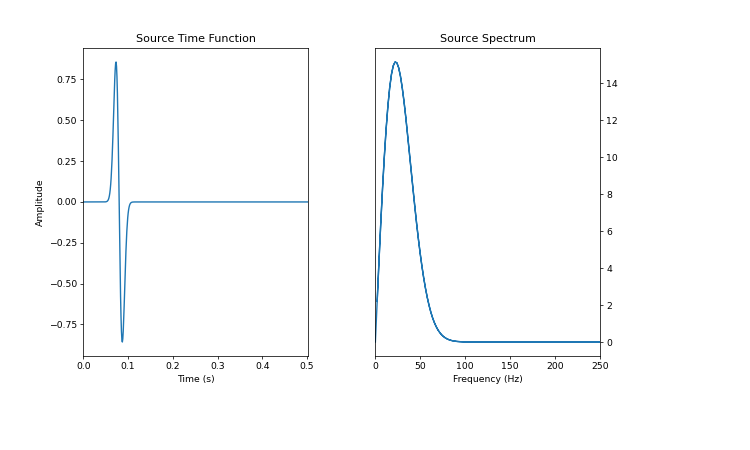

In [4]:
# Plot Source Time Function

# Position Configuration
plt.ion()
fig1 = plt.figure(figsize=(10, 6))
gs1 = gridspec.GridSpec(1, 2, width_ratios=[1, 1], hspace=0.3, wspace=0.3)

# Plot Source Time Function
ax1 = plt.subplot(gs1[0])
ax1.plot(time, src)  # plot source time function
ax1.set_title("Source Time Function")
ax1.set_xlim(time[0], time[-1])
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Amplitude")

# Plot Source Spectrum
ax2 = plt.subplot(gs1[1])
spec = np.fft.fft(src)  # source time function in frequency domain
freq = np.fft.fftfreq(spec.size, d=dt)  # time domain to frequency domain
ax2.plot(np.abs(freq), np.abs(spec))  # plot frequency and amplitude
ax2.set_xlim(0, 250)  # only display frequency from 0 to 250 Hz
ax2.set_title("Source Spectrum")
ax2.set_xlabel("Frequency (Hz)")

ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")

plt.show()

<IPython.core.display.Javascript object>


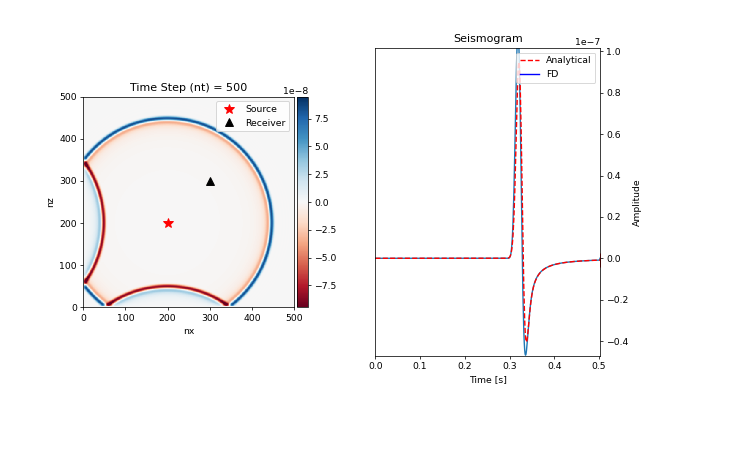

In [5]:
# Plot Snapshot & Seismogram (rerun this code again after simulation)

# Analytical Solution -- Green's Function
G = time * 0
r = np.sqrt((x[isx] - x[irx]) ** 2 + (z[isz] - z[irz]) ** 2)

for it in range(nt):
    if (time[it]) - r / c0 >= 0:
        G[it] = (1 / (2 * np.pi * c0**2)) * (
            1 / np.sqrt((time[it] ** 2) - (r**2 / c0**2))
        )
Gc = np.convolve(G, src * dt)
Gc = Gc[0:nt]
lim = Gc.max()  # get limit value from maximum amplitude of analytical solution

# Plot Position Configuration
plt.ion()
fig2 = plt.figure(figsize=(10, 6))
gs2 = gridspec.GridSpec(1, 2, width_ratios=[1, 1], hspace=0.3, wspace=0.3)

# Plot 2D Wave Propagation
# Note: comma is needed to update the variable
ax3 = plt.subplot(gs2[0])
(leg1,) = ax3.plot(
    isx, isz, "r*", markersize=11
)  # plot position of the source in model
(leg2,) = ax3.plot(
    irx, irz, "k^", markersize=8
)  # plot position of the receiver in model
im3 = ax3.imshow(p, vmin=-lim, vmax=+lim, interpolation="nearest", cmap=plt.cm.RdBu)
div = make_axes_locatable(ax3)
cax = div.append_axes("right", size="5%", pad=0.05)  # size & position of colorbar
fig2.colorbar(im3, cax=cax)  # plot colorbar
ax3.set_title("Time Step (nt) = 0")
ax3.set_xlim(0, nx)
ax3.set_ylim(0, nz)
ax3.set_xlabel("nx")
ax3.set_ylabel("nz")
ax3.legend(
    (leg1, leg2), ("Source", "Receiver"), loc="upper right", fontsize=10, numpoints=1
)

# Plot Seismogram
# Note: comma is needed to update the variable
ax4 = plt.subplot(gs2[1])
(up41,) = ax4.plot(time, seis)  # update seismogram each time step
(up42,) = ax4.plot([0], [0], "r|", markersize=15)  # update time step position
ax4.set_xlim(time[0], time[-1])
ax4.set_title("Seismogram")
ax4.set_xlabel("Time [s]")
ax4.set_ylabel("Amplitude")
(leg3,) = ax4.plot(0, 0, "r--", markersize=1)
(leg4,) = ax4.plot(0, 0, "b-", markersize=1)
ax4.legend(
    (leg3, leg4), ("Analytical", "FD"), loc="upper right", fontsize=10, numpoints=1
)

ax4.yaxis.tick_right()
ax4.yaxis.set_label_position("right")

plt.plot(time, Gc, "r--")
plt.show()

In [6]:
# 2D Wave Propagation (Finite Difference Solution)

# Calculate Partial Derivatives
for it in range(nt):
    if op == 3:  # 3-point operator scheme
        for i in range(1, nx - 1):
            d2px[i, :] = (p[i - 1, :] - 2 * p[i, :] + p[i + 1, :]) / dx**2
        for j in range(1, nz - 1):
            d2pz[j, :] = (p[:, j - 1] - 2 * p[:, j] + p[:, j + 1]) / dz**2
    if op == 5:  # use 5 point operator FD scheme
        for i in range(2, nx - 2):
            d2px[i, :] = (
                -1 / 12 * p[i + 2, :]
                + 4 / 3 * p[i + 1, :]
                - 5 / 2 * p[i, :]
                + 4 / 3 * p[i - 1, :]
                - 1 / 12 * p[i - 2, :]
            ) / dx**2
        for j in range(2, nz - 2):
            d2pz[:, j] = (
                -1 / 12 * p[:, j + 2]
                + 4 / 3 * p[:, j + 1]
                - 5 / 2 * p[:, j]
                + 4 / 3 * p[:, j - 1]
                - 1 / 12 * p[:, j - 2]
            ) / dz**2

    # Time Extrapolation
    pnew = 2 * p - pold + (c**2) * (dt**2) * (d2pz + d2px)

    # Add Source Term at isz and isx
    pnew[isz, isx] = pnew[isz, isx] + src[it] / (dz * dx) * dt**2

    # Remat Time Levels
    pold, p = p, pnew

    # Output Seismogram
    seis[it] = p[irz, irx]

    # Update Data for Wave Propagation Plot
    idisp = 5  # display frequency
    if (it % idisp) == 0:
        ax3.set_title("Time Step (nt) = %d" % it)
        ax3.imshow(p, vmin=-lim, vmax=+lim, interpolation="nearest", cmap=plt.cm.RdBu)
        up41.set_ydata(seis)
        up42.set_data(time[it], seis[it])
        plt.gcf().canvas.draw()